In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


data=pd.read_csv(r'롤롤.csv',encoding='euc-kr')
#print(data.info())
#print(data.shape)
#print(data.isnull().sum())

data=data.drop('gameId',axis=1)
# id 는 모델 분류하는데 영향을 미치지 않으므로 제거
lose=data[data['B승']==0]
win=data[data['B승']==1]
print(win.shape[0]/(win.shape[0]+lose.shape[0]))
print(win.shape[0])
print(lose.shape[0])

0.4990383642069035
4930
4949


In [2]:
#data=data[data.columns[:20]]
#data=data.drop(['B토탈골드','B경험치','B엘리트몬스터','B전령','BCS','B분당골드'],axis=1)
#print(data.head())
#b의 승은 b의 얻은량에 영향을 받으므로  레드팀에것은 제거
y=data['B승']
#X=data.drop('B승',axis=1)
X=data.drop(['B승','B엘리트몬스터','B전령','B토탈골드','B경험치','BCS','B골드차이','B경험치차이',
            'B분당골드','R와드', 'R와드파괴', 'R퍼블', 'R킬', 'R데스', 'R어시스트',
       'R엘리트몬스터','R전령','R토탈골드','R경험치'],axis=1)
X=X.drop(['R골드차이', 'R경험치차이','R분당골드'],axis=1)
X['분당cs차이']=X['B분당CS']-X['R분당CS']
X['레벨차이']=X['B평균레벨']-X['R평균레벨']
X=X.drop(['B분당CS','R분당CS','B평균레벨','R평균레벨'],axis=1)
col=X.columns

In [3]:
from sklearn.preprocessing import StandardScaler#수치형
from sklearn.preprocessing import LabelEncoder#범주형

In [4]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,make_scorer#정확도,민감도등
from sklearn.metrics import roc_curve #roc곡선그리기


In [5]:
#최적화
from sklearn.model_selection import cross_validate #교차타당도
from sklearn.pipeline import make_pipeline#파이프라인구축
from sklearn.model_selection import learning_curve#학습곡선,검증곡선
from sklearn.model_selection import GridSearchCV #하이퍼파라미티튜닝

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [6]:
X_train,X_test,y_train,y_test=\
    train_test_split(X,y,
    test_size=0.4,
    train_size=0.6,
    random_state=12354,
    shuffle=True)


stdc=StandardScaler()
X_train=stdc.fit_transform(X_train)
X_test=stdc.transform(X_test)
#x 데이터들을 표준화실시

In [7]:
#모델구축
logic=LogisticRegression(penalty='elasticnet',solver='saga',n_jobs=-1,l1_ratio=0.4)
logic.fit(X_train,y_train)
y_pred=logic.predict(X_test)

In [8]:
confmat=pd.DataFrame(confusion_matrix(y_test,y_pred),
index=['True[0]','True[1]'],
columns=['Predict[0]','predict[1]'])

In [9]:
print(confmat)
print(classification_report(y_test,y_pred)) 
# 현재 정확도 73%




from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

#동일한분포 아닐경우
from sklearn.model_selection import RepeatedKFold
#동일한분포이며, 특징들이 독립적일경우
from sklearn.model_selection import StratifiedKFold
repert=RepeatedKFold(n_splits=5,n_repeats=10)
kfold=StratifiedKFold(n_splits=5,shuffle=True)


         Predict[0]  predict[1]
True[0]        1410         515
True[1]         595        1432
              precision    recall  f1-score   support

           0       0.70      0.73      0.72      1925
           1       0.74      0.71      0.72      2027

    accuracy                           0.72      3952
   macro avg       0.72      0.72      0.72      3952
weighted avg       0.72      0.72      0.72      3952



In [10]:
train_sizes,train_scores,test_scores=\
    learning_curve(estimator=logic,#수정
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1,1.0,10),
    n_jobs=-1,
    cv=repert)


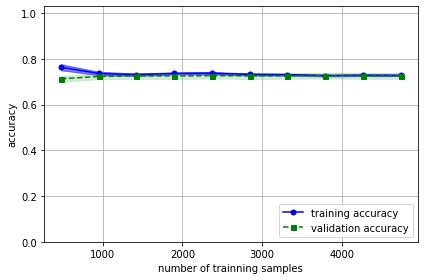

In [11]:

train_mean=np.mean(train_scores,axis=1)
train_std=np.std(train_scores,axis=1)
test_mean=np.mean(test_scores,axis=1)

test_std=np.std(test_scores,axis=1)

plt.plot(train_sizes,train_mean,
color='blue',marker='o',
markersize=5,label='training accuracy')

plt.fill_between(train_sizes,
train_mean+train_std,
train_mean-train_std,
alpha=0.5,color='blue')

plt.plot(train_sizes,test_mean,
color='green',linestyle='--',
marker='s',markersize=5,
label='validation accuracy')
plt.fill_between(train_sizes,
test_mean+test_std,
test_mean-test_std,
alpha=0.15,color='green')

plt.grid()
plt.xlabel('number of trainning samples')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim([0,1.03])#수정  y값의 범위
plt.tight_layout()
plt.show()

In [12]:
#roc_auc_score
fpr,tpr,thresholds=roc_curve(y_test,logic.predict_proba(X_test)[:,1])


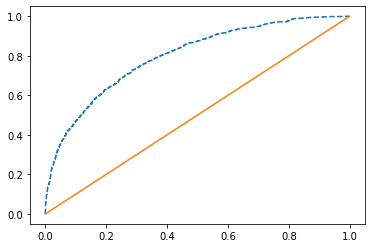

In [13]:
plt.plot(fpr,tpr,'--',label='logic')
plt.plot([0,1],[0,1],'-',label='50%')
plt.plot([fpr],[tpr],'r-',ms=10)
plt.show()

In [14]:
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve


In [15]:
cross_kfold=cross_validate(estimator=logic,X=X_train,y=y_train,cv=kfold,n_jobs=-1,
                          scoring=['accuracy','roc_auc'])

cross_repeat=cross_validate(estimator=logic,X=X_train,y=y_train,cv=repert,n_jobs=-1,scoring=['accuracy','roc_auc'])
                          
normal=cross_validate(estimator=logic,X=X_train,y=y_train,cv=10,n_jobs=-1,
                          scoring=['accuracy','roc_auc'])
#scoring 은 https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
#에서 참고

In [16]:
print("kfold정확도 test평균점수:",cross_kfold['test_accuracy'].mean()*100)
print("kfold정확도 test표준편차:",cross_kfold['test_accuracy'].std()*100)

kfold정확도 test평균점수: 72.6338079279356
kfold정확도 test표준편차: 0.6909408173921286


In [17]:
print(cross_repeat['test_accuracy'].mean()*100)
print(cross_repeat['test_accuracy'].std()*100)

72.61848713186899
1.1688168233516902


In [18]:
print(normal['test_accuracy'].mean()*100)
print(normal['test_accuracy'].std()*100)

#별차이가 없다

72.75146985096394
2.00191240814248


In [19]:
from sklearn.model_selection import RandomizedSearchCV
#하이퍼 파라미터값들을 랜덤적으로 지정해서 최상의 것을 찾는다
from sklearn.model_selection import GridSearchCV
#사용자가 지정한 범위내에 있는 요소들중 가장 기능이 좋은 하이퍼 파라미터를 찾는다
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
#print(logic.get_params())
# 로지스틱의 하이퍼 파마미터 출력

In [20]:
#param={'dual':True,'class_wight':'balanced'}

In [21]:
#random=RandomizedSearchCV(estimator=logic,n_iter=1,scoring='accuracy',n_jobs=-1,
#                         pre_dispatch=5,cv=cross_kfold,
#                         param_distributions=param)

In [22]:
#random.fit(X_train,y_train)

In [23]:
#paran_dist={'C':np.linspace(0.1,10,1).tolist(),
#            'max_iter':np.linspace(10,100,10).tolist(),
#            'l1_ratios':[0.1,0.3,0.4,0.8]
#           }

In [24]:
#grid=GridSearchCV(estimator=logic,param_grid=paran_dist,n_jobs=-1,cv=10,scoring='accuracy')

In [25]:
#grid.fit(X_train,y_train)

In [26]:
#print(logic.get_params())

In [27]:
logicpipe=make_pipeline(LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.5))

In [28]:
print(logicpipe.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'logisticregression', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticregression__penalty', 'logisticregression__random_state', 'logisticregression__solver', 'logisticregression__tol', 'logisticregression__verbose', 'logisticregression__warm_start'])


In [29]:
logicpipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=0.5, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='elasticnet', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [30]:
#param_pca=[1,2,3,4,5,6,7,8,9]
param_l1_ratio=[0.1,0.2,0.3,0.4,0.5,0.6,0.7]
param_penalty=['elasticnet']
param_solver=['saga']
param_gid=[{'logisticregression__l1_ratio':param_l1_ratio,
           'logisticregression__solver':param_solver}]

In [31]:
gs=GridSearchCV(estimator=logicpipe,param_grid=param_gid,scoring='accuracy',cv=repert,n_jobs=-1)

In [32]:
gs.fit(X_train,y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=None),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=0.5,
                                                           max_iter=100,
                                                           multi_class='auto',
                                                           n_jobs=None,
                                                           penalty='elasticnet',
                                   

In [33]:
print(gs.cv_results_)

{'mean_fit_time': array([0.01918622, 0.02389861, 0.02819118, 0.03041026, 0.02848534,
       0.02739099, 0.01850723]), 'std_fit_time': array([0.0017372 , 0.00493419, 0.00328626, 0.00278476, 0.00199454,
       0.00257782, 0.00135817]), 'mean_score_time': array([0.00052077, 0.00064211, 0.00069224, 0.00069654, 0.00069803,
       0.00064547, 0.00051624]), 'std_score_time': array([6.09197832e-05, 2.26017252e-04, 5.48293319e-05, 8.34850527e-05,
       2.21542007e-04, 1.04042855e-04, 8.14979964e-05]), 'param_logisticregression__l1_ratio': masked_array(data=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_logisticregression__solver': masked_array(data=['saga', 'saga', 'saga', 'saga', 'saga', 'saga', 'saga'],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'logisticregression__l1_ratio': 0.1, 'logistic

In [34]:
print(gs.best_score_.mean())

0.7259163233504813


In [35]:
print(gs.best_params_)

{'logisticregression__l1_ratio': 0.7, 'logisticregression__solver': 'saga'}


In [36]:
print(gs.best_estimator_)

Pipeline(memory=None,
         steps=[('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=0.7, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='elasticnet', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)


In [37]:
new=gs.best_estimator_
y_pred_gs=new.predict(X_test)

In [38]:
confmat1=pd.DataFrame(confusion_matrix(y_test,y_pred_gs),
index=['True[0]','True[1]'],
columns=['Predict[0]','predict[1]'])
print(confmat1)
print('Classification Report')
print(classification_report(y_test,y_pred_gs))


         Predict[0]  predict[1]
True[0]        1410         515
True[1]         595        1432
Classification Report
              precision    recall  f1-score   support

           0       0.70      0.73      0.72      1925
           1       0.74      0.71      0.72      2027

    accuracy                           0.72      3952
   macro avg       0.72      0.72      0.72      3952
weighted avg       0.72      0.72      0.72      3952



In [39]:
train_sizes,train_scores,test_scores=\
    learning_curve(estimator=new,#수정
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1,1.0,10),
    n_jobs=-1,
    cv=repert)

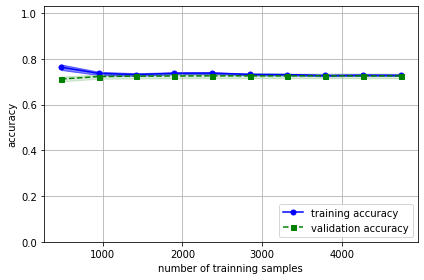

In [40]:

train_mean=np.mean(train_scores,axis=1)
train_std=np.std(train_scores,axis=1)
test_mean=np.mean(test_scores,axis=1)

test_std=np.std(test_scores,axis=1)

plt.plot(train_sizes,train_mean,
color='blue',marker='o',
markersize=5,label='training accuracy')

plt.fill_between(train_sizes,
train_mean+train_std,
train_mean-train_std,
alpha=0.5,color='blue')

plt.plot(train_sizes,test_mean,
color='green',linestyle='--',
marker='s',markersize=5,
label='validation accuracy')
plt.fill_between(train_sizes,
test_mean+test_std,
test_mean-test_std,
alpha=0.15,color='green')

plt.grid()
plt.xlabel('number of trainning samples')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim([0,1.03])#수정  y값의 범위
plt.tight_layout()
plt.show()

In [41]:
new_logic=LogisticRegression(l1_ratio=0.5, penalty='elasticnet',
                                    solver='saga',n_jobs=-1)

In [42]:
new_logic.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.5, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [43]:
print("B값들 {}".format(new_logic.coef_))
#골드차이가 가장 영향을준다는걸 알수있다

B값들 [[-0.02980044  0.02227965  0.0195468   0.58823281 -0.62591047  0.01071448
   0.16239631  0.08975747  0.17104782 -0.13267991 -0.00348922 -0.05801881
  -0.04466978  0.20492655  0.35327421]]


In [44]:
fram=pd.DataFrame(data=X_train,columns=col)

In [45]:
print(fram)

           B와드     B와드파괴       B퍼블        B킬       B데스     B어시스트    B드래곤전령  \
0     0.911867  0.542521 -0.995455 -0.052946 -0.056005 -0.649430 -0.751176   
1    -0.455503  0.085121  1.004566 -1.382662 -0.394034 -1.142598 -0.751176   
2    -0.350321  3.286921  1.004566 -0.717804 -1.408121 -0.649430 -0.751176   
3    -0.455503  0.085121 -0.995455  0.279483  1.296110 -0.649430  1.331246   
4    -0.192547  2.372121 -0.995455 -1.382662 -0.732063 -1.142598 -0.751176   
...        ...       ...       ...       ...       ...       ...       ...   
5922 -0.350321  0.085121 -0.995455 -1.382662 -0.394034 -1.389182 -0.751176   
5923 -0.350321 -0.372279  1.004566  1.941627 -0.056005  0.830073  1.331246   
5924 -0.402912 -0.829679  1.004566  1.609198 -1.070092  1.076657  1.331246   
5925 -0.455503 -0.829679 -0.995455  0.279483  0.620052  0.336905 -0.751176   
5926 -0.297730 -0.372279 -0.995455 -0.717804 -0.056005 -0.896014 -0.751176   

         B타워파괴    B정글몬스터      R드래곤     R타워파괴       RCS    R정글몬스

In [46]:
corr=X.corr()

In [47]:
print(corr)
import seaborn as sns

             B와드     B와드파괴       B퍼블        B킬       B데스     B어시스트    B드래곤전령  \
B와드     1.000000  0.034447  0.003228  0.018138 -0.002612  0.033217  0.017676   
B와드파괴   0.034447  1.000000  0.017717  0.033748 -0.073182  0.067793  0.040504   
B퍼블     0.003228  0.017717  1.000000  0.269425 -0.247929  0.229485  0.134309   
B킬      0.018138  0.033748  0.269425  1.000000  0.004044  0.813667  0.170436   
B데스    -0.002612 -0.073182 -0.247929  0.004044  1.000000 -0.026372 -0.188852   
B어시스트   0.033217  0.067793  0.229485  0.813667 -0.026372  1.000000  0.170873   
B드래곤전령  0.017676  0.040504  0.134309  0.170436 -0.188852  0.170873  1.000000   
B타워파괴   0.009462 -0.009150  0.083316  0.180314 -0.071441  0.123663  0.039750   
B정글몬스터  0.010501 -0.023452  0.018190 -0.112506 -0.228102 -0.134023  0.159595   
R드래곤   -0.020121 -0.034439 -0.135327 -0.207949  0.150746 -0.189563 -0.631930   
R타워파괴  -0.008225 -0.023943 -0.069584 -0.082491  0.156780 -0.060880 -0.032865   
RCS    -0.012395  0.040023 -0.156711 -0.

/Users/leonilpark/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 50752 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/leonilpark/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 46300 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/leonilpark/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 54028 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/leonilpark/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 44340 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/leonilpark/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 54140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/leonilpark/opt/anaconda3/lib/pyth

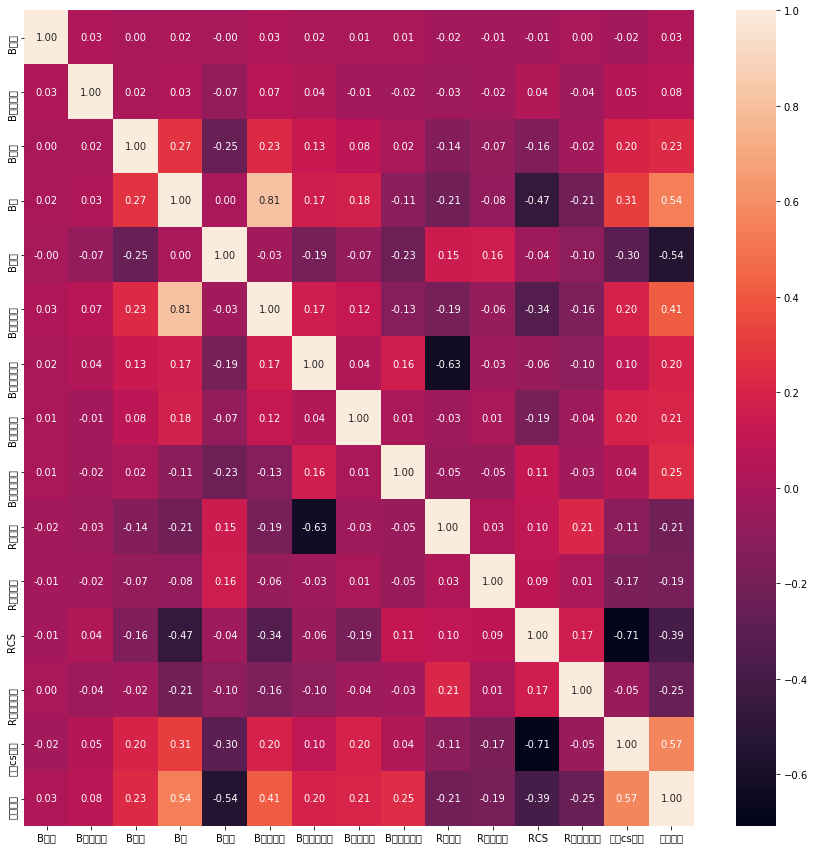

In [48]:
plt.figure(figsize=(15,15))
sns.heatmap(data=corr,annot=True,fmt='.2f')
plt.show()

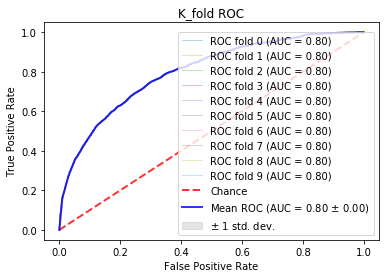

In [49]:
import numpy as np
import matplotlib.pyplot as plt



from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=10)
classifier = LogisticRegression(penalty='elasticnet',solver='saga',n_jobs=-1,l1_ratio=0.4)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train2, test2) in enumerate(cv.split(X_train, y_train)):
    classifier.fit(X_test, y_test)
    viz = plot_roc_curve(classifier, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="K_fold ROC")
ax.legend(loc="lower right")
plt.show()


In [50]:
confmat1=pd.DataFrame(confusion_matrix(y_test,y_pred_gs),
index=['True[0]','True[1]'],
columns=['Predict[0]','predict[1]'])
print(confmat1)
print('Classification Report')
print(classification_report(y_test,y_pred_gs))

         Predict[0]  predict[1]
True[0]        1410         515
True[1]         595        1432
Classification Report
              precision    recall  f1-score   support

           0       0.70      0.73      0.72      1925
           1       0.74      0.71      0.72      2027

    accuracy                           0.72      3952
   macro avg       0.72      0.72      0.72      3952
weighted avg       0.72      0.72      0.72      3952



In [51]:
import statsmodels.api as sm

xts=StandardScaler()
X=xts.fit_transform(X)
logit_mod=sm.Logit(y,X)
result=logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.536300
         Iterations 6


In [52]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                     B승   No. Observations:                 9879
Model:                          Logit   Df Residuals:                     9864
Method:                           MLE   Df Model:                           14
Date:                Thu, 30 Jul 2020   Pseudo R-squ.:                  0.2263
Time:                        18:03:55   Log-Likelihood:                -5298.1
converged:                       True   LL-Null:                       -6847.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0266      0.024     -1.125      0.261      -0.073       0.020
x2             0.0048      0.024      0.199      0.842      -0.043       0.052
x3             0.0625      0.025      2.500      0.0

In [53]:
print(np.exp(result.params))

x1     0.973797
x2     1.004822
x3     1.064504
x4     1.783728
x5     0.558072
x6     1.032507
x7     1.158843
x8     1.096316
x9     1.188934
x10    0.892214
x11    0.953905
x12    1.013409
x13    0.909354
x14    1.287761
x15    1.406182
dtype: float64
